# 5. Generating some toy data with zfit and performing a maximum-likelihood fit

In this example (borrowed from [here](https://zfit.readthedocs.io/en/stable/getting_started/examples.html)), we generate some toy data events from a set of signal and background functions we define. We then fit the combined sample in order to measure the signal fraction and the shape parameters. 

Some imports of what we need:

In [1]:
import numpy as np
import zfit
import matplotlib.pyplot as plt

#Gives us nice LaTeX fonts in the plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

We start of by creating our fit observable `obs`, which is the variable we want to fit (`x`):

In [6]:
low = -10
high = 10
obs = zfit.Space("x", limits=(low, high))

Define the signal peak mean (`mu`) and width (`sigma`), the background exponential parameter (`lambda`), and the fraction of signal (`frac`). 

In [3]:
mu = zfit.Parameter("mu", 1., -4, 6)
sigma = zfit.Parameter("sigma", 1., 0.1, 10)
lambd = zfit.Parameter("lambda", -0.06, -1, -0.01)
frac = zfit.Parameter("fraction", 0.3, 0, 1)

Here we create a signal Gaussian function (`gauss`) using `mu` and `sigma`, and define it in the `obs` observable space. We also define a background exponential, then sum the two PDFs together into a total PDF (`model`). The signal and background are added together with a relative fraction `frac`.

In [4]:
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
exponential = zfit.pdf.Exponential(lambd, obs=obs)
model = zfit.pdf.SumPDF([gauss, exponential], fracs=frac)

Let's make some toy data from the PDF, in order to try out some fitting. We make $10,000$ events, and base our generation of `data` on the `model` total PDF:

In [ ]:
n_sample = 10000

exp_data = exponential.sample(n=n_sample * (1 - frac)).numpy()

gauss_data = gauss.sample(n=n_sample * frac).numpy()

data = model.create_sampler(n_sample, limits=obs)
data.resample()

Let's move the parameter values in our PDF to some different values, to give the fit some work to do!

In [ ]:
mu.set_value(0.5)
sigma.set_value(1.2)
lambd.set_value(-0.05)
frac.set_value(0.07)

We can plot what our data and PDF look like at this stage:

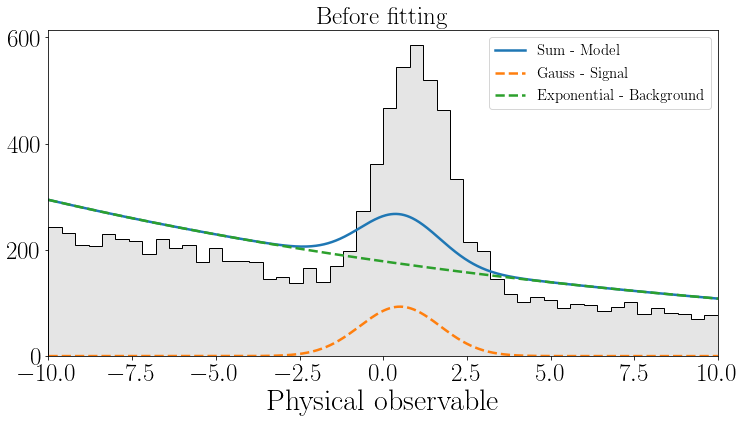

In [15]:
data_np = data[:, 0].numpy()
color = 'black'
n_bins = 50

linewidth = 2.5
plot_scaling = n_sample / n_bins * obs.area()

x = np.linspace(low, high, 1000)

# plot the pdf BEFORE fitting
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Before fitting",fontsize=25)
# plot the data
plt.hist(data_np, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
plt.hist(data_np, color=color, bins=n_bins, histtype="step")
# plot the pdfs
y = model.pdf(x).numpy()
y_gauss = (gauss.pdf(x) * frac).numpy()  # notice the frac!
y_exp = (exponential.pdf(x) * (1 - frac)).numpy()  # notice the frac!

plt.plot(x, y * plot_scaling, label="Sum - Model", linewidth=linewidth)
plt.plot(x, y_gauss * plot_scaling, '--', label="Gauss - Signal", linewidth=linewidth)
plt.plot(x, y_exp * plot_scaling, '--', label="Exponential - Background", linewidth=linewidth)
plt.xlim(low,high)
plt.xlabel("Physical observable",fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=15)
plt.show()

Now let's do some fitting with zfit. We create a negative log-likelihood (`nll`), which is based on our total PDF (`model`) and toy dataset (`data`).

In [16]:
# create NLL
nll = zfit.loss.UnbinnedNLL(model=model, data=data)

Now we set up a `Minuit` minimiser, and give the `nll` to it. This tells `Minuit` to minimise the negative lo-likelihood of `model` with respect to `data`, in other words to do a maximum likelihood fit.  

In [17]:
# create a minimizer
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

# do the error calculations, here with Hesse
param_hesse = result.hesse()
param_errors, _ = result.errors()
print(result.params)

/afs/cern.ch/work/d/dhill/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.833e+04                  │       Ncalls = 111 (111 total)       │
│ EDM = 6.89e-05 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


/afs/cern.ch/work/d/dhill/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:362: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  "in the future, add it explicitly as in `errors(method='minuit_minos')`", FutureWarning)


name         value    minuit_hesse         minuit_minos    at limit
--------  --------  --------------  -------------------  ----------
fraction     0.282     +/-  0.0068  - 0.0068   + 0.0068       False
mu          0.9829     +/-   0.027  -  0.028   +  0.027       False
sigma       0.9959     +/-   0.026  -  0.025   +  0.026       False
lambda    -0.05846     +/-  0.0022  - 0.0022   + 0.0022       False


The fit has now run, and returned us values for the various parameters as well as their uncertainties. How do they compare to the values we initially used to generate the toy dataset?

We can look at how our PDF compares to the data now we have run our fit:

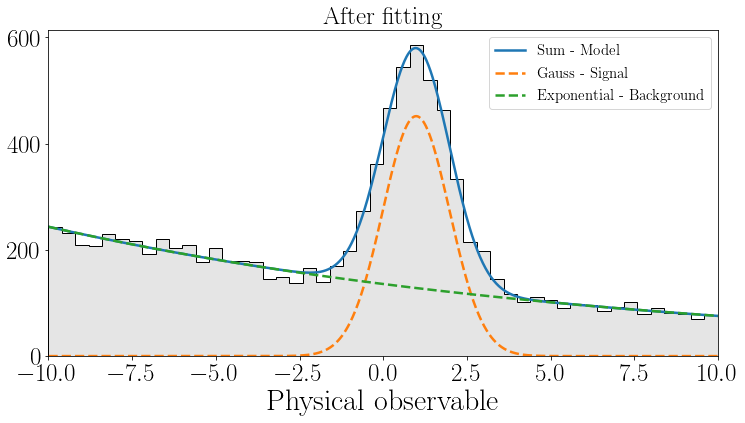

In [19]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("After fitting",fontsize=25)
# plot the data
plt.hist(data_np, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
plt.hist(data_np, color=color, bins=n_bins, histtype="step")
# plot the pdfs
y = model.pdf(x).numpy()
y_gauss = (gauss.pdf(x) * frac).numpy()  # notice the frac!
y_exp = (exponential.pdf(x) * (1 - frac)).numpy()  # notice the frac!

plt.plot(x, y * plot_scaling, label="Sum - Model", linewidth=linewidth)
plt.plot(x, y_gauss * plot_scaling, '--', label="Gauss - Signal", linewidth=linewidth)
plt.plot(x, y_exp * plot_scaling, '--', label="Exponential - Background", linewidth=linewidth)
plt.xlim(low,high)
plt.xlabel("Physical observable",fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=15)
plt.show()

The fit has found best values for the various parameters, and as a result the total PDF now agrees very well with the toy dataset.

**Follow-up tasks**
- Can you apply the methods here to fit the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ signal MC sample? Will you need a background model for that fit?
- Can you fit the data using a similar fit to the one above? Remember, we want to measure the normalisation yield rather than a signal fraction, so you need to get the fit to measure an `n_sig` and `n_bkg`. Look at the "Signal-background-mass fit extended" options in the `zfit` examples.